# 4. Tuning the kernel "by eye"
## II. Hand-tuning GP kernels on OJ 287 short cadence

M. Gully-Santiago  
July 15, 2019
Kepler/K2 GO Office

Yay, short cadence!

In [1]:
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import scope
import lightkurve as lk
import everest

In [3]:
from nfft import nfft

Let's turn off `DEBUG` logging messages.

In [4]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
bok_log = logging.getLogger('bokeh') 
bok_log.setLevel(logging.WARNING) 
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

# What does the real data look like in a PSD?

First let's get genuine data to simulate its properties as close as we can.

In [5]:
lc_tpf = lk.search_targetpixelfile('EPIC 211991001', mission='K2', cadence='long', campaign=5).download()

In [6]:
sc_tpf = lk.search_targetpixelfile('EPIC 211991001', mission='K2', cadence='short', campaign=5).download()

You can use `tpf.interact()` to generate a *custom* aperture mask, **or** take the exact same mask as Everest.  Let's do both!

In [7]:
import everest

In [8]:
lc_Everest = everest.Everest(211991001, season=5, mission='k2')

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 211991001.


In [9]:
aperture_mask = lc_Everest.aperture.astype(np.bool)

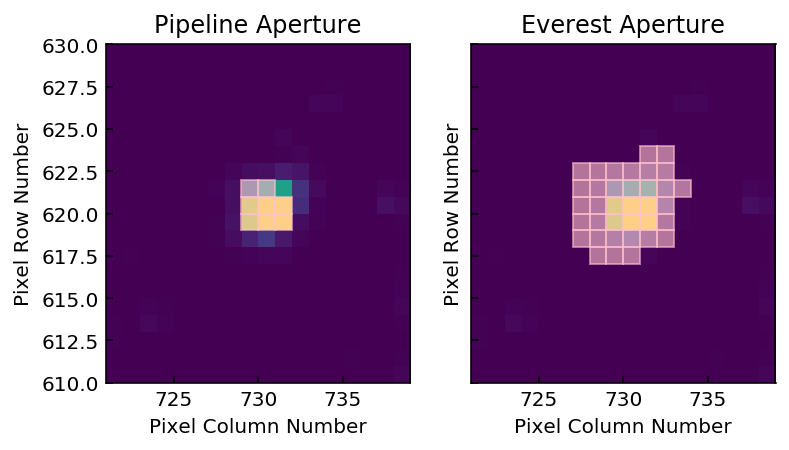

In [10]:
fig, axarr = plt.subplots(1,2, sharey=True)

lc_tpf.plot(aperture_mask=lc_tpf.pipeline_mask, ax=axarr[0], show_colorbar=False)
axarr[0].set_title('Pipeline Aperture')

lc_tpf.plot(aperture_mask=aperture_mask, ax=axarr[1],show_colorbar=False)
axarr[1].set_title('Everest Aperture');

In [11]:
#lc_tpf.interact(aperture_mask=aperture_mask)

I inspected the Everest aperture with interact and see that most of the available signal has been captured for most of the duration of the campaign.  So we will employ the Everest aperture for any custom analysis.  Using the same aperture as Everest also offers a head-to-head comparison of custom methods to Everest.

In [12]:
lc = lc_tpf.to_lightcurve(aperture_mask=aperture_mask)

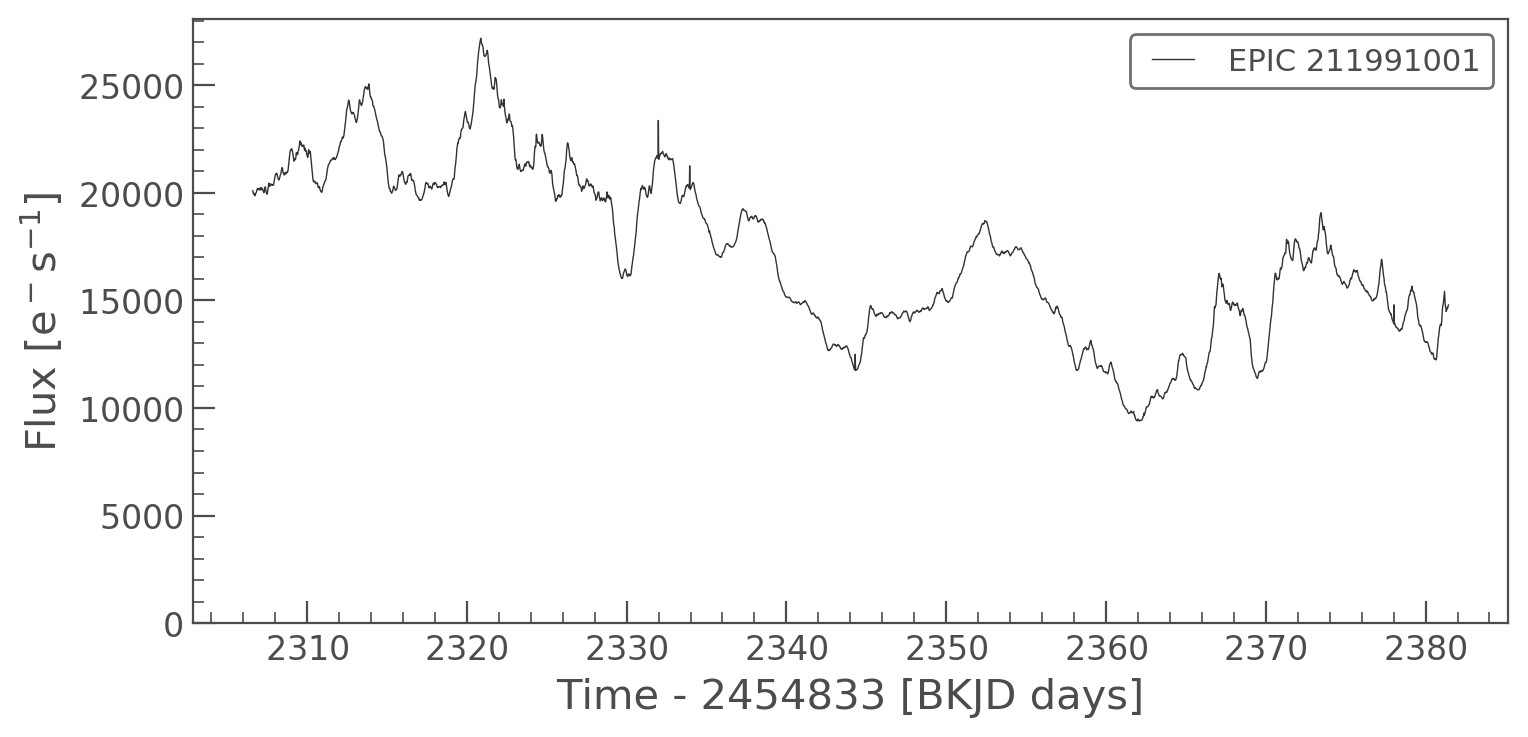

In [13]:
lc.plot(normalize=False)
plt.ylim(0);

The signal-to-noise ratio is extremely high.

## Data pre-processing

#### What do do about non-uniform time sampling?

In [14]:
t_gaps = ((lc.time[1:] - lc.time[0:-1])*u.day).to(u.hour)

In [15]:
np.max(t_gaps)

<Quantity 1.96146661 h>

The largest gap is four consecutive 30-minute cadences.

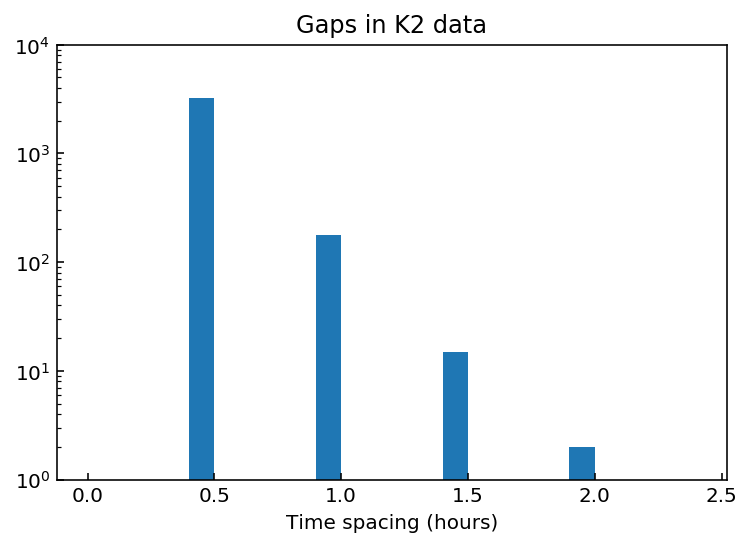

In [16]:
plt.hist(t_gaps.value, bins=np.arange(0, 2.5, 0.1));
plt.yscale('log')
plt.xlabel('Time spacing (hours)')
plt.title("Gaps in K2 data")
plt.ylim(1e0, 1e4);

We *do not* have evenly spaced frequencies, so we technically shouldn't use the numpy implementation of FFT from the celerite example.  Instead we should use the `NFFT` algorithm:
https://github.com/jakevdp/nfft  
This algorithm requires some extra preprocessing and tuning, so I will leave that as an exercise for the future, or as a feature addition to `lightkurve`.

We can also "fill gaps".

In [17]:
lc.time.shape, lc.fill_gaps().time.shape

((3450,), (3663,))

The problem with "filling gaps" is that the inserted data may alter the Power Spectral Density slope in a way that may be difficult to quantify or detect...  

Let's go back at the end and explore how filling gaps affects the data.  We'll save a pristine copy for later.

In [18]:
lc_pristine = lc.copy()
lc = lc.fill_gaps(method='nearest')

lc_pristine_short = sc_tpf.to_lightcurve(aperture_mask=aperture_mask)
lc_short = lc_pristine_short.fill_gaps(method='nearest')

In [19]:
t = (lc.time*u.day).to(u.second).value
t_short = (lc_short.time*u.day).to(u.second).value
NN = len(lc.time)
NN_short = len(lc_short.time)

## Compute the normalized power spectra with two methods

In [20]:
fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-2) *1e5

WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead
WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead


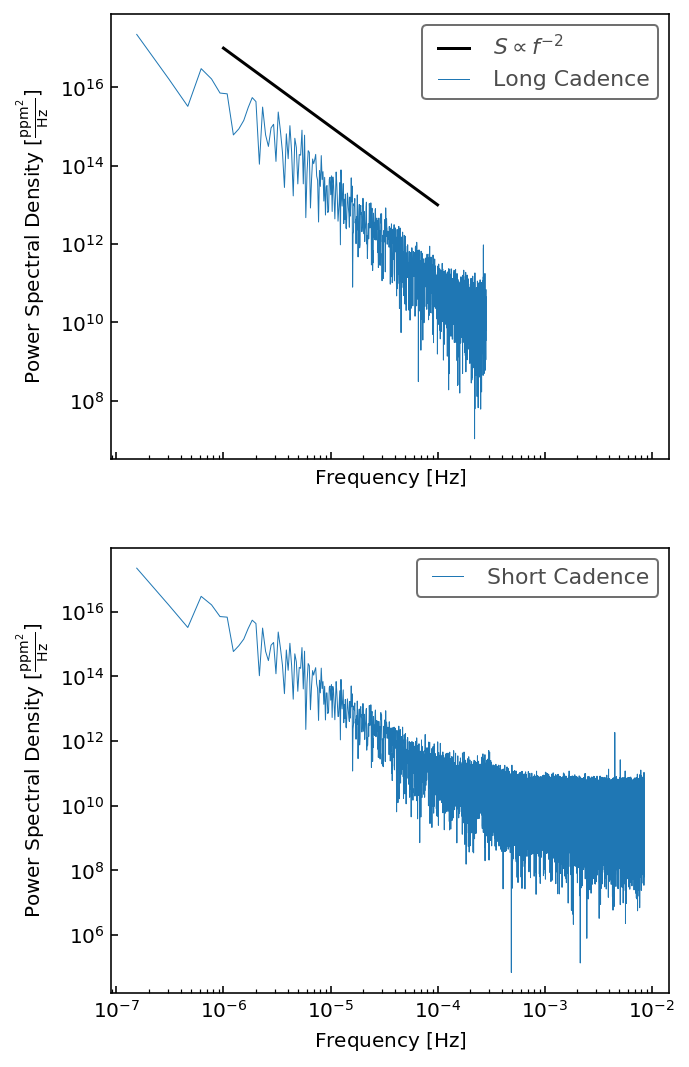

In [21]:
fig, axarr = plt.subplots(2, sharex=True, figsize=(5, 9))

axarr[0].plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-2}$')
pg = lc.to_periodogram(freq_unit=u.Hz, normalization='psd')
pg.plot(scale='log', label='Long Cadence', ax=axarr[0])


pg_short = lc_short.to_periodogram(freq_unit=u.Hz, normalization='psd')
pg_short.plot(scale='log', label='Short Cadence', ax=axarr[1])


## Model the PSD with a Damped Random Walk

In [22]:
t_char = (0.3*u.year).to(u.second)

In [23]:
c_val = 2.0*np.pi * 1/(t_char)

In [24]:
c_val.to(u.Hz) # units of Hertz

<Quantity 6.63673759e-07 Hz>

What about the value of $a$?  It should have units of $(\mathrm{dimensionless\; power}\cdot \mathrm{Hz})$, so it should be comparable to $c$ to achieve near-unity power.

In [25]:
a_val = c_val*9e12

In [26]:
a_val.to(u.Hz)

<Quantity 5973063.8329717 Hz>

We can use `celerite` to simulate the PSD.

In [27]:
from astropy.stats import LombScargle

import celerite
from celerite import terms

Note that celerité follows the numpy convention of **natural logs** $\ln{}$ for all $\log{}$ functions, unless explicitly providing base 10.

>Args:  
    - log_a (float): The log of the amplitude of the term.  
    - log_c (float): The log of the exponent of the term.

In [28]:
true_logc, true_loga = np.log(c_val.value) , np.log(a_val.value)
kernel = terms.RealTerm(log_a=true_loga, log_c=true_logc) 
gp = celerite.GP(kernel, fit_mean=True, mean=lc.flux.mean())
gp.compute(t_short)
y = gp.sample()

In [29]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])
f_short = np.fft.rfftfreq(len(t_short), t_short[-1] - t_short[-2])

In [30]:
power_true = kernel.get_psd(2*np.pi*f_short)
# >>> To get the true PSD in units of physical frequency, normalize by 2*pi <<<
power_true /= 2*np.pi

In [31]:
f_short.shape, lc_short.flux.shape

((54946,), (109890,))

WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead
WARNING [astropy._showwarning()]: AstropyDeprecationWarning: Importing LombScargle from astropy.stats has been deprecated and will no longer be supported in future. Please import this class from the astropy.timeseries module instead


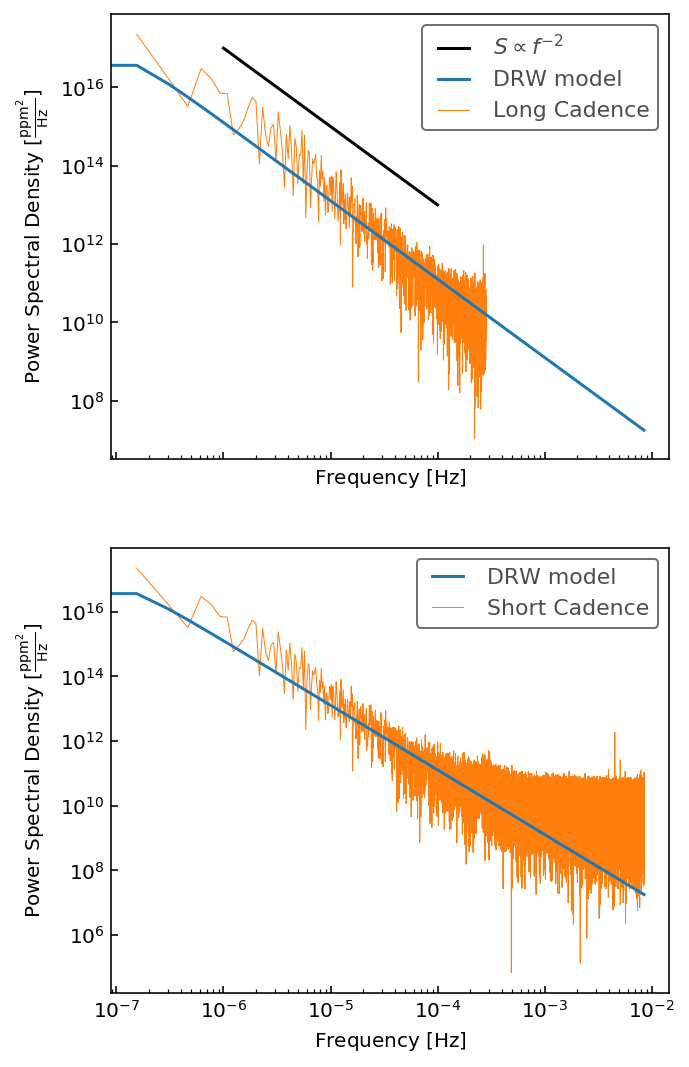

In [32]:
fig, axarr = plt.subplots(2, sharex=True, figsize=(5, 9))

axarr[0].plot(fake_omega, fake_pow, 'k-', label='$S \propto f^{-2}$')
axarr[0].plot(f_short, power_true*1e5, label="DRW model")

pg = lc.to_periodogram(freq_unit=u.Hz, normalization='psd')
pg.plot(scale='log', label='Long Cadence', ax=axarr[0], zorder=0)

axarr[1].plot(f_short, power_true*1e5, label="DRW model")
pg_short = lc_short.to_periodogram(freq_unit=u.Hz, normalization='psd')
pg_short.plot(scale='log', label='Short Cadence', ax=axarr[1], zorder=0);


Let's plot the model in the time domain.

(0, 28062.102685546874)

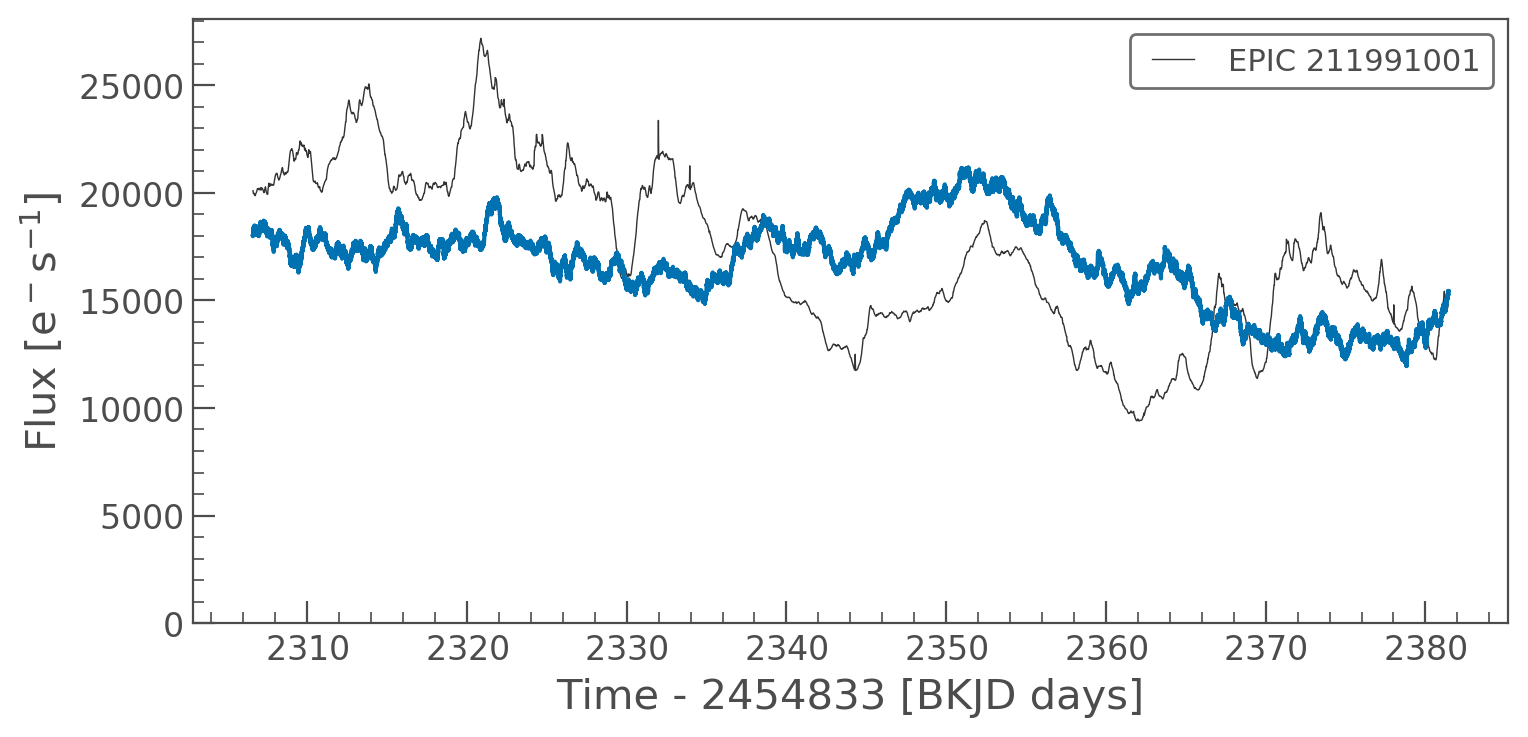

In [33]:
ax = lc.plot(normalize=False)
ax.plot(lc_short.time, y, label='simulation')
plt.ylim(0)

Indeed, the draw from the random walk process has more high-frequency structure than the genuine source.  The power law slope of OJ 287 is more negative than $-2$.

We want to model the structure *exactly*.  Let's try a model that allows for more flexible tuning of the power law slope, a CARMA model.